# RL Methods (Q Learning) for the Inverted Pendulum Problem


### Install All Necessaery Libraries/Packages

In [95]:
!apt-get update
!apt-get install -y xvfb python3-opengl ffmpeg
!pip install gym pyvirtualdisplay

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 229 kB in 1s (248 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newes

In [96]:
# Install packages
import gym
import copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import time
from pyvirtualdisplay import Display
import os
import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64

### Creating Results Folder

In [97]:
# Create a main results directory
results_dir = "/content/results"
os.makedirs(results_dir, exist_ok=True)

def create_timestamped_subdir():
    """
    Create a timestamped subdirectory in the results directory.
    """
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    subdir = os.path.join(results_dir, timestamp)
    os.makedirs(subdir, exist_ok=True)
    return subdir

subdir = create_timestamped_subdir()

## Environment

Source: [https://gym.openai.com/envs/CartPole-v1/](Open AI Gym).

In [98]:
env = gym.envs.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Plotting Function

In [99]:
def plot_res(values, title=''):
    """ Plot the reward curve and histogram of results over time. """
    # Update the window after each episode
    clear_output(wait=True)

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## Deep Q Learning

In [100]:
class DQN(nn.Module):
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
            super(DQN, self).__init__()
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def forward(self, state):
        # Define the forward pass of the model.
        return self.model(state)

    def update(self, state, y):
        # Update the weights of the network given a training sample.
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        # Compute Q values for all actions using the DQL.
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [101]:
def q_learning(env, model, episodes, gamma,
               epsilon, eps_decay=0.995,
               replay=False, replay_size=100,
               title = 'DQL', double=False,
               n_update=10, soft=False, verbose=True):
    """ Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0

    avg_cart_positions_per_episode = []
    avg_cart_velocities_per_episode = []
    avg_pole_angles_per_episode = []
    avg_pole_velocities_per_episode = []


    for episode in range(episodes):
        episode_i+=1
        cart_positions, cart_velocities, pole_angles, pole_velocities = [], [], [], []
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()

        # Reset state
        state = env.reset()
        done = False
        total = 0

        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -50

            # Extract real-time data
            cart_pos, cart_vel, pole_angle, pole_vel = next_state
            cart_positions.append(cart_pos)
            cart_velocities.append(cart_vel)
            pole_angles.append(pole_angle)
            pole_velocities.append(pole_vel)

            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()

            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else:
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state

        # Calculate and store episode summaries
        avg_cart_positions_per_episode.append(np.mean(cart_positions))
        avg_cart_velocities_per_episode.append(np.mean(cart_velocities))
        avg_pole_angles_per_episode.append(np.mean(pole_angles))
        avg_pole_velocities_per_episode.append(np.mean(pole_velocities))

        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)

        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)

    ''' The plotting code for testing

    # Dashboard-style plotting at the end of the function
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Performance Dashboard', fontsize=16)

    episodes_range = range(1, episodes + 1)

    # Plot for Average Cart Position
    axs[0, 0].plot(episodes_range, avg_cart_positions_per_episode, label='Cart Position', color='blue')
    if replay:
      plt.savefig(os.path.join(subdir, "rdqn_cart_position_plot.png"))
    else:
      plt.savefig(os.path.join(subdir, "dqn_cart_position_plot.png"))
    axs[0, 0].set_title('Cart Position')
    axs[0, 0].set_xlabel('Episodes')
    axs[0, 0].set_ylabel('Position')
    axs[0, 0].legend()

    # Plot for Average Cart Velocity
    axs[0, 1].plot(episodes_range, avg_cart_velocities_per_episode, label='Cart Velocity', color='green')
    if replay:
      plt.savefig(os.path.join(subdir, "rdqn_cart_velocities_plot.png"))
    else:
      plt.savefig(os.path.join(subdir, "dqn_cart_velocities_plot.png"))
    axs[0, 1].set_title('Cart Velocity')
    axs[0, 1].set_xlabel('Episodes')
    axs[0, 1].set_ylabel('Velocity')
    axs[0, 1].legend()

    # Plot for Average Pole Angle
    axs[-1, 0].plot(episodes_range, avg_pole_angles_per_episode, label='Pole Angle', color='red')
    if replay:
      plt.savefig(os.path.join(subdir, "rdqn_pole_angles_plot.png"))
    else:
      plt.savefig(os.path.join(subdir, "dqn_pole_angles_plot.png"))
    axs[-1, 0].set_title('Pole Angle')
    axs[-1, 0].set_xlabel('Episodes')
    axs[-1, 0].set_ylabel('Angle')
    axs[-1, 0].legend()

    # Plot for Average Pole Velocity
    axs[-1, 1].plot(episodes_range, avg_pole_velocities_per_episode, label='Pole Velocity', color='purple')
    if replay:
      plt.savefig(os.path.join(subdir, "rdqn_pole_velocities_plot.png"))
    else:
      plt.savefig(os.path.join(subdir, "dqn_pole_velocities_plot.png"))
    axs[-1, 1].set_title('Pole Velocity')
    axs[-1, 1].set_xlabel('Episodes')
    axs[-1, 1].set_ylabel('Velocity')
    axs[-1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()
    '''

    '''
    Plotting code for paper
    '''
    # Dashboard-style plotting at the end of the function
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Cart Position and Pole Angle Over Episodes', fontsize=16)

    episodes_range = range(1, episodes + 1)

    # Plot for Average Cart Position and Average Pole Angle
    ax.plot(episodes_range, avg_cart_positions_per_episode, label='Cart Position', color='blue')
    ax.plot(episodes_range, avg_pole_angles_per_episode, label='Pole Angle', color='red')
    # ax.set_title('Cart Position and Pole Angle')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Value')
    ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()

    torch.save(model.state_dict(), 'dqn_model.pth')

    return final

### Parameters

In [102]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 300
# Number of hidden nodes in the DQN
n_hidden = 128
# Learning rate
lr = 0.001
# Gamma
gamma = 0.9
# Epsilon
epsilon = 0.3

### Train The DQN Model

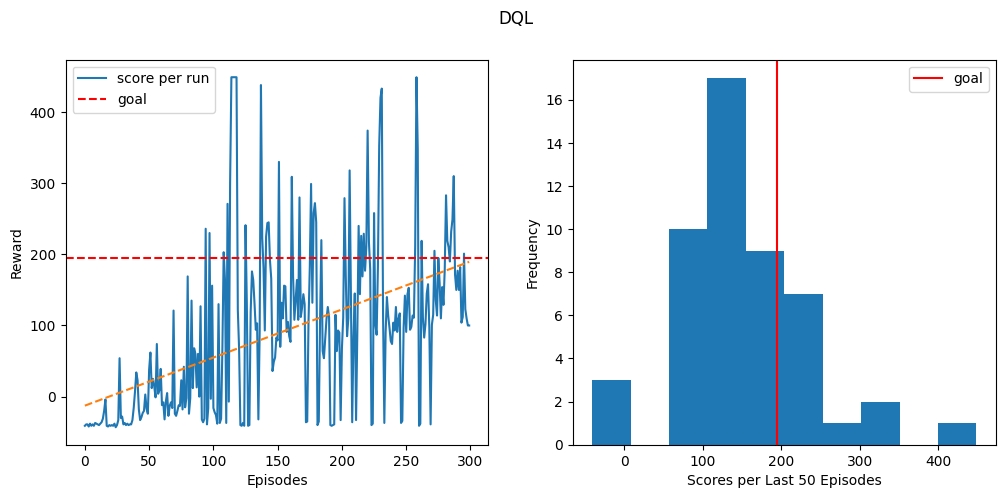

episode: 300, total reward: 100.0


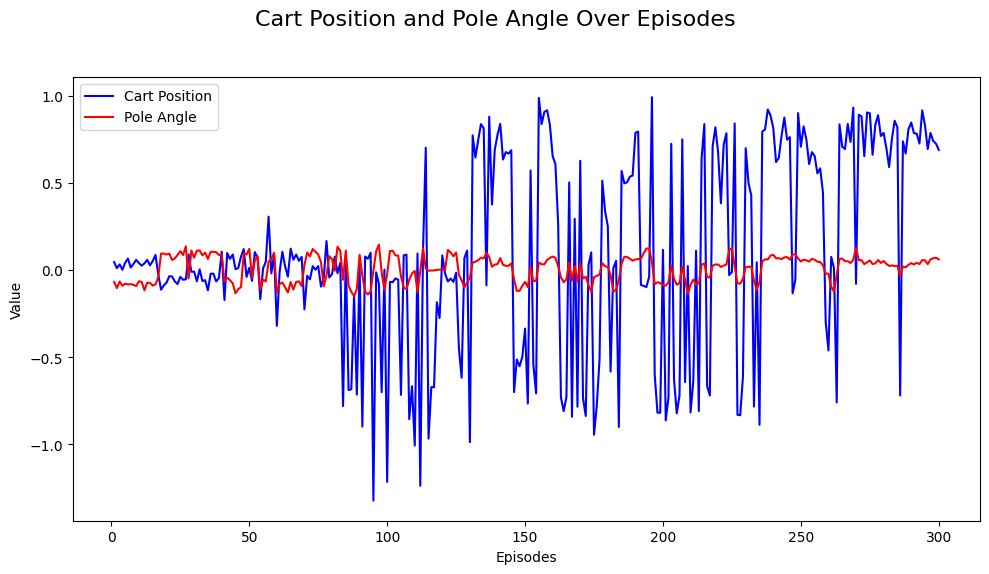

In [103]:
model = DQN(n_state, n_action, n_hidden, lr)
train_dqn = q_learning(env, model, episodes, gamma, epsilon)

### Visualize Cart Pole Simulation

In [104]:
model.load_state_dict(torch.load('dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

DQN(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [105]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [106]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML, display  # Import display

def visualize_model(model, env_name, subdir, episode_num):
    """
    Visualize the model performance in the environment and save the video.
    """
    video_path = os.path.join(subdir, f"dqn_video_{episode_num}")
    os.makedirs(video_path, exist_ok=True)

    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_path, episode_trigger=lambda episode: True)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()
        state, reward, done, _ = env.step(action)
    env.close()

    # Display the video
    mp4list = glob.glob(f'{video_path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print("Could not find video")


for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
    if episode % 300 == 0:
        visualize_model(model, 'CartPole-v1',"/videos",episode)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

## DQN + Replay

In [107]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    def replay(self, memory, size, gamma):
        """Replay function"""
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]

            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)

            is_dones_indices = torch.where(is_dones_tensor==True)[0]

            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


            self.update(states.tolist(), all_q_values.tolist())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Train The DQN + Replay Model

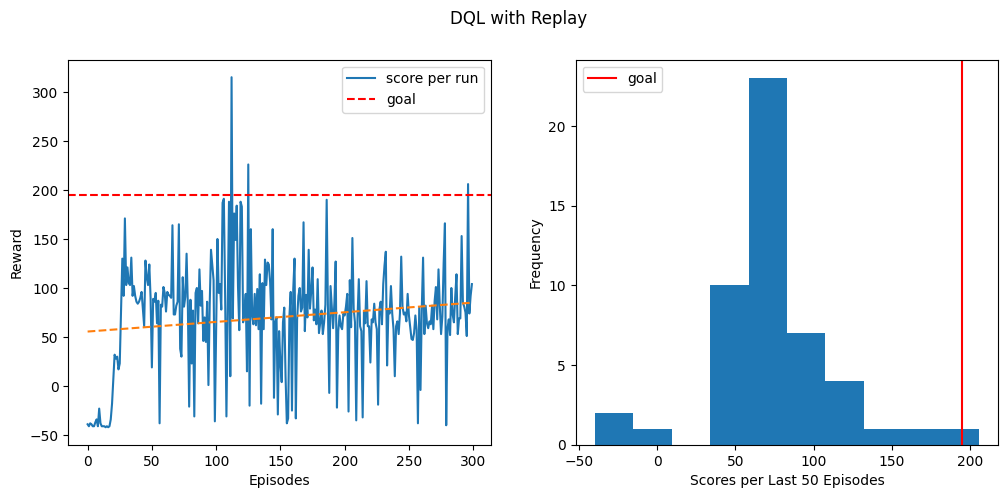

episode: 300, total reward: 104.0
Average replay time: 0.49395837386449176


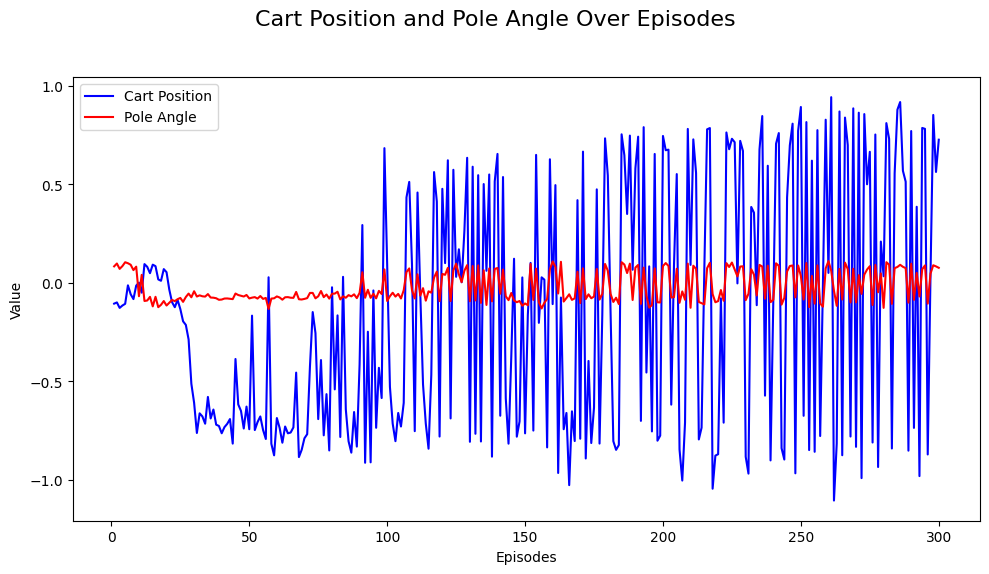

In [108]:
model = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, model,
                    episodes, gamma,
                    epsilon, replay=True,
                    title='DQL with Replay')

### Visualize Cart Pole Simulation

In [109]:
model.load_state_dict(torch.load('dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

DQN_replay(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [110]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [111]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML, display  # Import display

def visualize_model(model, env_name, subdir, episode_num):
    """
    Visualize the model performance in the environment and save the video.
    """
    video_path = os.path.join(subdir, f"dqn_video_{episode_num}")
    os.makedirs(video_path, exist_ok=True)

    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_path, episode_trigger=lambda episode: True)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()
        state, reward, done, _ = env.step(action)
    env.close()

    # Display the video
    mp4list = glob.glob(f'{video_path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print("Could not find video")


for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
    if episode % 300 == 0:
        visualize_model(model, 'CartPole-v1',"/videos",episode)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

## Dual DQN

In [112]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)

    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))

    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())

    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            data = random.sample(memory, size)
            states = []
            targets = []
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Train Dual DQN Model

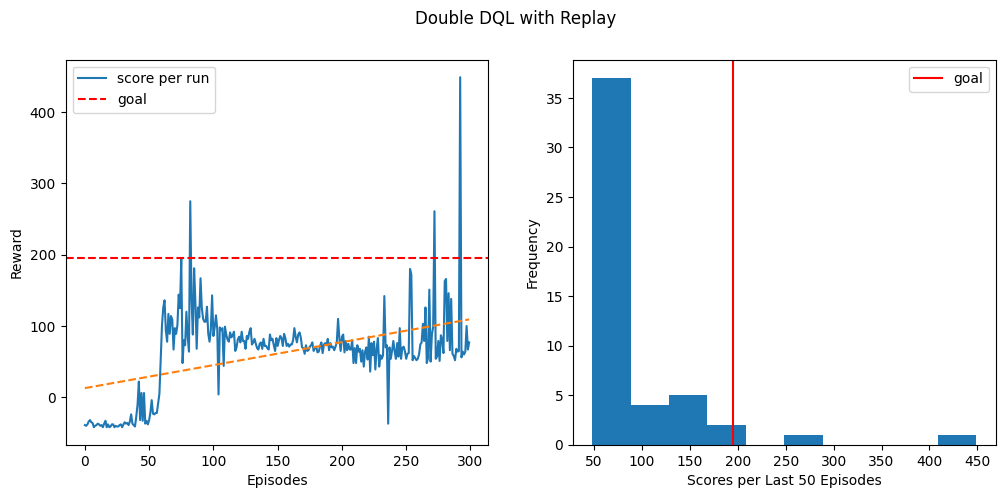

episode: 300, total reward: 77.0
Average replay time: 3.1224032362302143


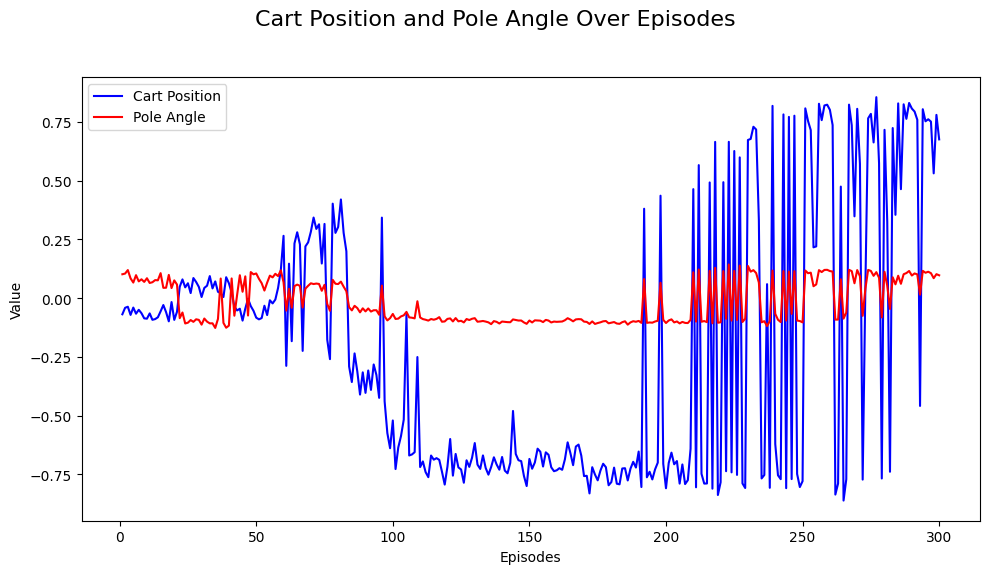

In [113]:
model = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, model, episodes, gamma,
                    epsilon, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)

### Visualize Cart Pole Simulation

In [114]:
model.load_state_dict(torch.load('dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

DQN_double(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (target): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [115]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [116]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML, display  # Import display

def visualize_model(model, env_name, subdir, episode_num):
    """
    Visualize the model performance in the environment and save the video.
    """
    video_path = os.path.join(subdir, f"dqn_video_{episode_num}")
    os.makedirs(video_path, exist_ok=True)

    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_path, episode_trigger=lambda episode: True)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()
        state, reward, done, _ = env.step(action)
    env.close()

    # Display the video
    mp4list = glob.glob(f'{video_path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print("Could not find video")


for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
    if episode % 300 == 0:
        visualize_model(model, 'CartPole-v1',"/videos",episode)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

## Single Layer DQN

In [117]:
class DQN(nn.Module):
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super(DQN, self).__init__()
        self.criterion = torch.nn.MSELoss()
        # Single linear layer
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, action_dim)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def forward(self, state):
        # Define the forward pass of the model.
        return self.model(state)

    def update(self, state, y):
        # Update the weights of the network given a training sample.
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        # Compute Q values for all actions using the DQL.
        with torch.no_grad():
            return self.model(torch.Tensor(state))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get Single Layer DQN Results

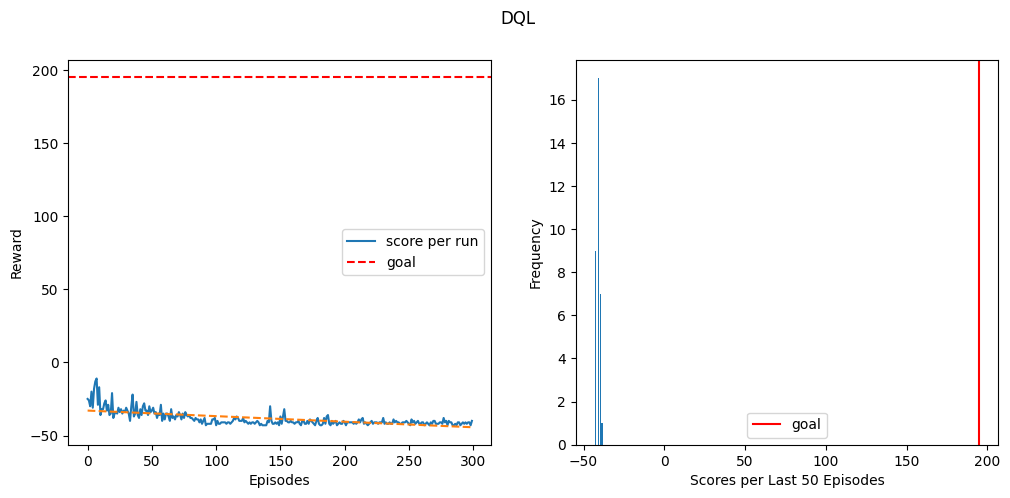

episode: 300, total reward: -40.0


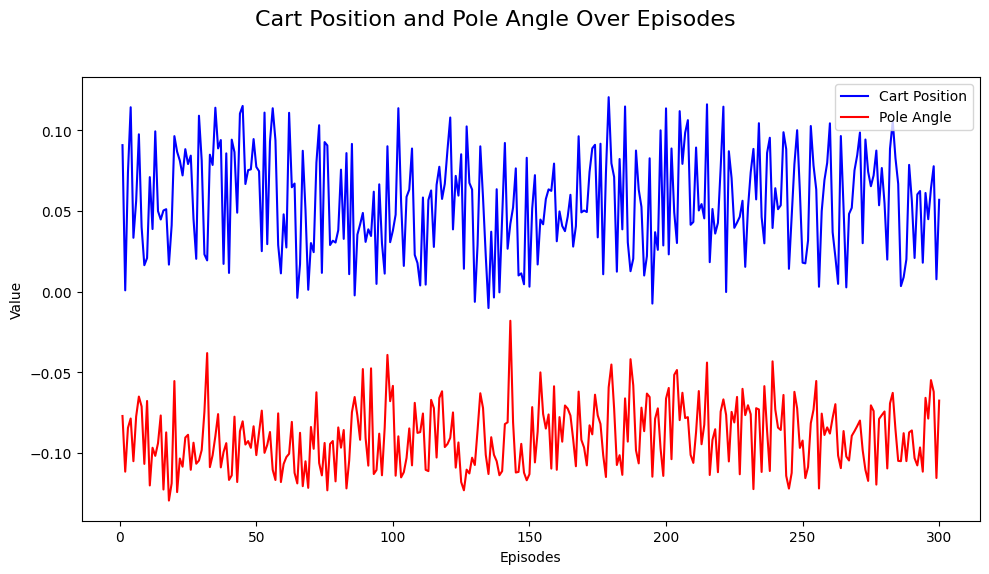

In [118]:
model = DQN(n_state, n_action, n_hidden, lr)
train_dqn = q_learning(env, model, episodes, gamma, epsilon)

### Visualize Cart Pole Simulation

In [119]:
model.load_state_dict(torch.load('dqn_model.pth'))
model.eval()  # Set the model to evaluation mode

DQN(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [120]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [121]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

import gym
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML, display  # Import display

def visualize_model(model, env_name, subdir, episode_num):
    """
    Visualize the model performance in the environment and save the video.
    """
    video_path = os.path.join(subdir, f"dqn_video_{episode_num}")
    os.makedirs(video_path, exist_ok=True)

    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_path, episode_trigger=lambda episode: True)
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()
        state, reward, done, _ = env.step(action)
    env.close()

    # Display the video
    mp4list = glob.glob(f'{video_path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the latest video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print("Could not find video")


for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            action_probs = model(torch.from_numpy(state).float())
            action = torch.argmax(action_probs).item()

        state, reward, done, _ = env.step(action)
    if episode % 300 == 0:
        visualize_model(model, 'CartPole-v1',"/videos",episode)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

## Q-Table Learning

In [122]:
def qtable(state_space,action_space,bin_size = 30):
    ''' Q Table class. '''
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]

    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

def discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
def episode_trigger(episode_id):
  return episode_id % 100 == 0

def q_learning(q_table, bins, episodes = 5000, gamma = 0.95,
               lr = 0.1, timestep = 5000, epsilon = 0.2,
               episode_trigger=None):
    rewards = 0
    solved = False
    steps = 0
    runs = [0]
    data = {'max' : [0], 'avg' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1,timestep)]

    env = gym.make('CartPole-v0', render_mode='human')
    env = RecordVideo(env, './cartpole-video.mp4', episode_trigger=episode_trigger)

    for episode in range(1,episodes+1):

        current_state = discrete(env.reset(),bins) # initial observation
        score = 0
        done = False
        temp_start = time.time()

        if episode_trigger(episode):
          env.start_video_recorder()

        while not done:
            steps += 1
            ep_start = time.time()
            if episode%timestep == 0:
                env.render()

            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])

            observation, reward, done, info = env.step(action)
            next_state = discrete(observation,bins)

            score += reward


            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = next_state

        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            if score > 195 and steps >= 100 and solved == False: # considered as a solved:
                solved = True
                print('Solved in episode : {} in time {}'.format(episode, (time.time()-ep_start)))

        # Timestep value update
        if episode%timestep == 0:
            print('Episode : {} | Reward -> {} | Max reward : {} | Time : {}'.format(episode,rewards/timestep, max(runs), time.time() - ep_start))
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            if rewards/timestep >= 195:
                print('Solved in episode : {}'.format(episode))
            rewards, runs= 0, [0]

    if len(ep) == len(data['max']):
        plt.axhline(y=200, color='r', linestyle=':')
        plt.plot(ep, data['avg'], label = 'Avgerage Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.legend(loc = "upper left")

    env.close()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:89: UserWarning: WARN: Disabling video recorder because environment <TimeLimit<OrderEnforcing<StepAPICompatibility<Passiv

Solved in episode : 250 in time 0.019173145294189453
Episode : 1000 | Reward -> 81.907 | Max reward : 200.0 | Time : 0.02124309539794922
Episode : 2000 | Reward -> 113.631 | Max reward : 200.0 | Time : 0.020713090896606445
Episode : 3000 | Reward -> 129.648 | Max reward : 200.0 | Time : 0.020580053329467773
Episode : 4000 | Reward -> 131.95 | Max reward : 200.0 | Time : 0.020595312118530273
Episode : 5000 | Reward -> 144.455 | Max reward : 200.0 | Time : 0.019530296325683594


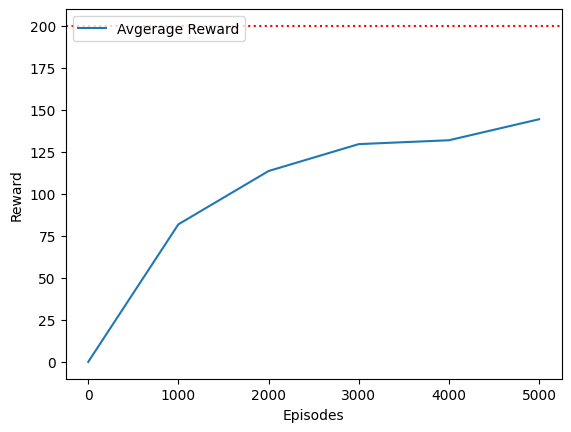

In [124]:
q_table, bins = qtable(len(env.observation_space.low), env.action_space.n)

q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5*10**3, timestep = 1000, episode_trigger=episode_trigger)

## References:

(1) Reinforcement Q-Learning from Scratch in Python with OpenAI Gym. (2019). Learndatasci.com. Retrieved 9 December 2019, from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

(2) Paszke, A., (2019). Reinforcement Learning (DQN) tutorial. Retrieved from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

(3) Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., ... & Wierstra, D. (2015). Continuous control with deep reinforcement learning. arXiv preprint arXiv:1509.02971.

(4) Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning. In Thirtieth AAAI conference on artificial intelligence.

(5) Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., Lanctot, M., & De Freitas, N. (2015). Dueling network architectures for deep reinforcement learning. arXiv preprint arXiv:1511.06581.

(6) Double DQN Implementation to Solve OpenAI Gym’s CartPole v-0. (2019). Medium. Retrieved 20 December 2019, from https://medium.com/@leosimmons/double-dqn-implementation-to-solve-openai-gyms-cartpole-v-0-

(7) Kurban, Rita. (2019) Deep Q Learning for the CartPole. Medium. https://towardsdatascience.com/deep-q-learning-for-the-cartpole-44d761085c2f